In [1]:
from models.utils import set_global_seed
set_global_seed(42)
from torchvision.datasets import FashionMNIST
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torchvision import transforms
import PIL
from models.predefined import InstanceDependentNoiseAdder
from models.cleaner import NoiseCleaner

# Noise Affect

In [2]:
def plot_tsne(X, y, noise_ratio):
    plt.style.use('seaborn-v0_8-whitegrid')
    tsne = TSNE(n_components=2, perplexity=5, max_iter=1000, random_state=42)
    X_tsne = tsne.fit_transform(X)

    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7,
                         edgecolors='none', s=80)
    ax.set_title(f"t-SNE Visualization with Noise Ratio {noise_ratio}", fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    plt.tight_layout()
    plt.show()


In [3]:
def get_image_size(dataset):
    sample, _ = dataset[0]
    if isinstance(sample, PIL.Image.Image):
        sample = transforms.ToTensor()(sample)
    return sample.shape[0] * sample.shape[1] * sample.shape[2]

Seed: 66
Seed: 75
Seed: 85


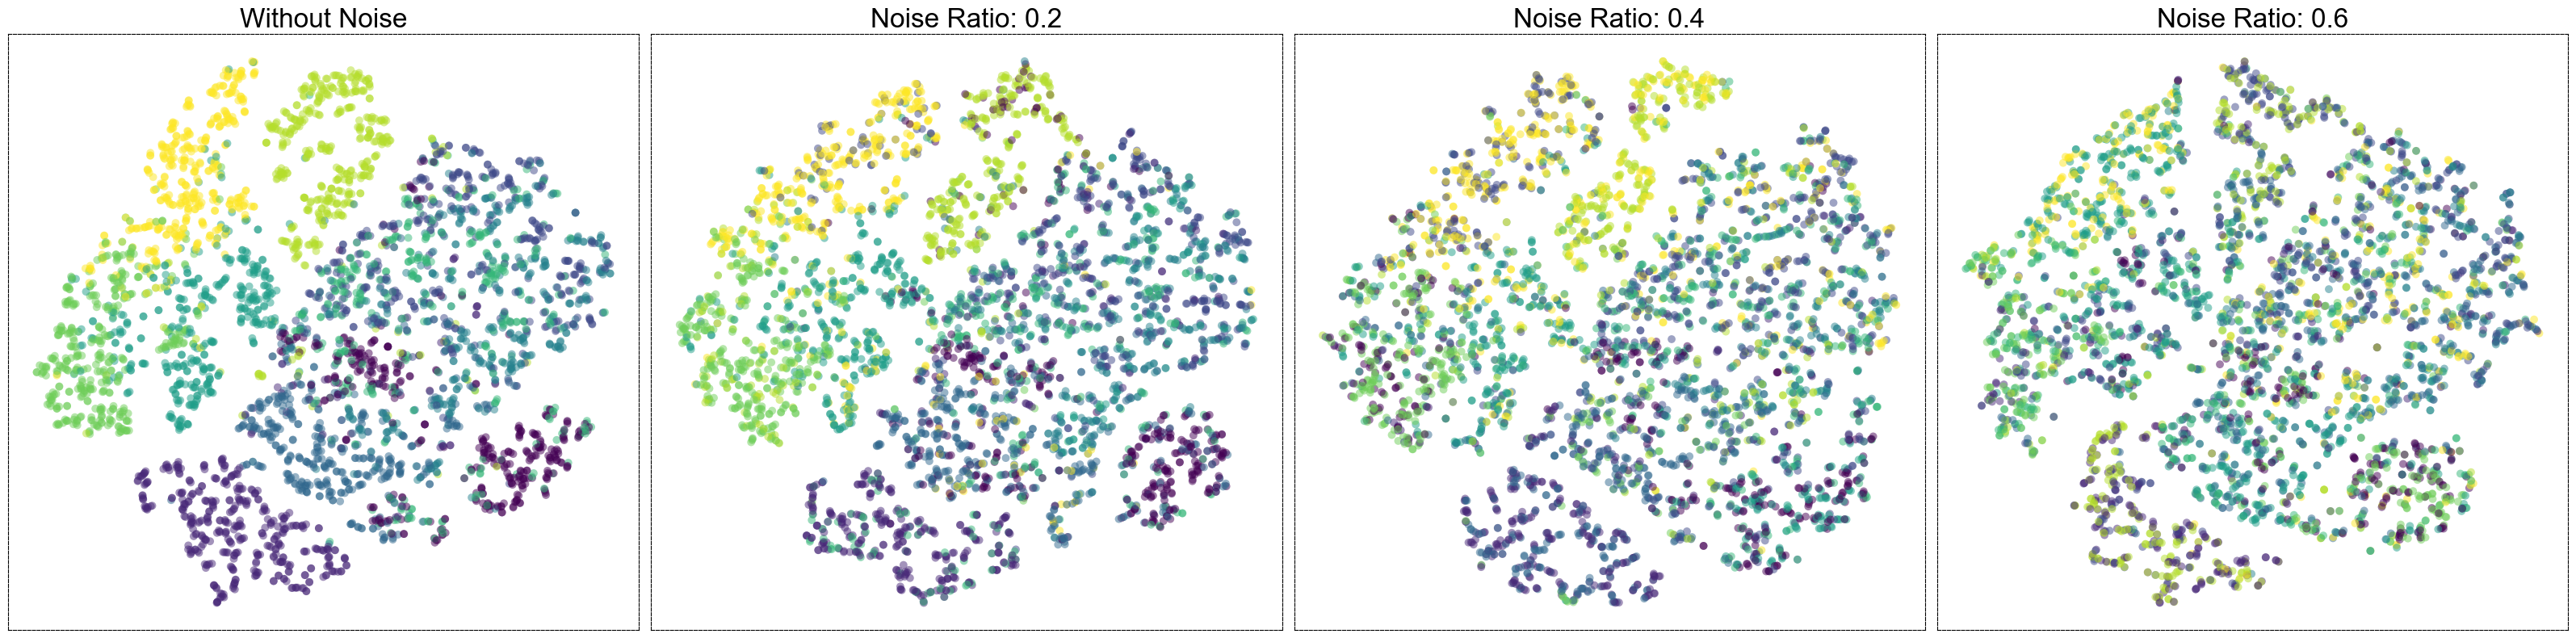

In [7]:
plt.rcParams['font.family'] = 'Arial'

fig, axes = plt.subplots(1, 4, figsize=(32, 8), dpi=100)
ratios = [0, 0.2, 0.4, 0.6]

for ax, ratio in zip(axes.flatten(), ratios):
    ds = FashionMNIST(root='./data', train=True, download=True)
    if ratio != 0:
        _image_size = get_image_size(ds)
        noise_adder = InstanceDependentNoiseAdder(ds, image_size=_image_size, ratio=ratio, num_classes=10)
        noise_adder.add_noise()
        
    n_total = ds.data.shape[0]
    n_sample = n_total // 15
    sample_idx = np.random.choice(n_total, size=n_sample, replace=False)
    X_sample = ds.data[sample_idx].reshape(n_sample, -1)
    y_sample = np.array(ds.targets)[sample_idx]
    
    tsne = TSNE(n_components=2, perplexity=5, max_iter=1000)
    X_tsne = tsne.fit_transform(X_sample)
    
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, cmap='viridis', alpha=0.5,
               edgecolors='none', s=50)
    
    font_size = 24
    if ratio == 0:
        ax.set_title("Without Noise", fontsize=font_size)
    else:
        ax.set_title(f"Noise Ratio: {ratio}", fontsize=font_size)

    for spine in ax.spines.values():
        spine.set_linestyle('--')
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

plt.tight_layout()
plt.savefig("vectorized_figure.pdf", format="pdf", bbox_inches='tight')
plt.show()

# Latent With Noise

In [2]:
train_dataset = FashionMNIST(root='data', train=True, download=False)
transform = transforms.Compose([
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor()])
augmented_transform = transforms.Compose([
                                # transforms.RandomCrop(size=32, padding=4),
                                # transforms.RandomHorizontalFlip(),
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor()])

noise_cleaner = NoiseCleaner(train_dataset, noise_type='idn', model_save_path="fmnist(20)/resnet18/model_resnet18_fmnist(20)_fold_{}.pth", 
                             inner_folds_num=10, outer_folds_num=10, model='resnet34', train_noise_level=0.2, epochs_num=1000, train_pairs=200000, 
                             val_pairs=20000, embedding_dimension=128, lr=5e-5, optimizer='Adam', patience=12, transform=transform,
                             weight_decay=1e-3, training_batch_size=2048, pre_trained=False, dropout_prob=0.5, contrastive_ratio=1,
                             distance_meter='euclidian', augmented_transform=augmented_transform, trainable=True, pair_validation=False,
                             label_smoothing=0.1, loss='ce', margin=2, freeze_epoch=None, noisy_indices_path='preds/fmnist(20)/resnet34/fold{}_noisy_indices.csv',
                             prediction_path='preds/fmnist(20)/resnet34/fold{}_analysis.csv', mistakes_count=10, relabeling_range=range(6, 11))

Seed: 51
noise count: 12496 out of 60000 data


In [9]:
noise_cleaner.analyze_fold_latent(fold=9, cmap_txt='tab10')

analyzing latent space for big fold 10
number_of_pairs: 4309


Evaluating Noisy Samples: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


In [11]:
dataset = noise_cleaner.dataset
N = len(dataset)
first_img, first_label = dataset[0]
d = 28*28

emb_first = np.zeros((N, d))
true_labels = np.zeros(N, dtype=int)
is_noisy = np.zeros(N, dtype=bool)
noisy_indices = noise_cleaner.train_noise_adder.noisy_indices

for i in range(N):
    img, label = dataset[i]
    emb_first[i] = np.array(img).ravel()
    true_labels[i] = label
    is_noisy[i] = (i in noisy_indices)

# Compute t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb2d = tsne.fit_transform(emb_first)

# Create clean plot
plt.figure(figsize=(6, 6), dpi=300)
cmap = plt.get_cmap('tab10')

# Base scatter: colored by class
plt.scatter(
    emb2d[:, 0], emb2d[:, 1],
    c=true_labels, cmap=cmap, s=15, alpha=0.8, linewidth=0
)

# Overlay noisy circles
plt.scatter(
    emb2d[is_noisy, 0], emb2d[is_noisy, 1],
    facecolors='none', edgecolors='black',
    s=30, linewidths=0.5, alpha=0.4
)

# Remove all axis elements
plt.gca().set_axis_off()

# Save to PDF (vectorized)
plt.tight_layout(pad=0)
plt.savefig("tsne_latent.pdf", format='pdf', bbox_inches='tight')
plt.close()

AttributeError: 'Image' object has no attribute 'cpu'